## Airlines Tweets Sentiments
### Negative, positive and neutral tweets about airlines companies
     0 = Negative
     1 = Neutral
     2 = Positive

## Importing all the necessary libraries

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import dython
from datetime import datetime
from dateutil import parser
import openpyxl
import spacy
sns.set_theme(style = 'whitegrid')

In [89]:
tweets = pd.read_csv('airline-tweets-sentiments.csv')
tweets.head()

,_id,tweet_text,tweet_lang,tweet_sentiment_value
0,595e60b48fcd022a715f7b7b,this @airfrance b777-300er has the oldest ifes...,en,0
1,595e60de8fcd022a715f7b7d,???? will miss my connection @airfrance https:...,en,0
2,595e61448fcd022a715f7b7f,"@airfrance lost luggage in overhead cabin, ema...",en,0
3,595e62748fcd022a715f7b83,"here's a new twist on the ""all airlines hate m...",en,0
4,595e62b28fcd022a715f7b86,@airfrance so now i might not have 3 pieces of...,en,0


In [90]:
tweets.shape

(1097, 4)

## Lets add a text label to show the sentiments

In [91]:
tweets["label"] = tweets["tweet_sentiment_value"].apply(lambda x: "Negative" if x == 0 else "Neutral" if x == 1 else "Positive" )
label_count = tweets['label'].value_counts()
label_count 

Neutral     502
Negative    406
Positive    189
Name: label, dtype: int64

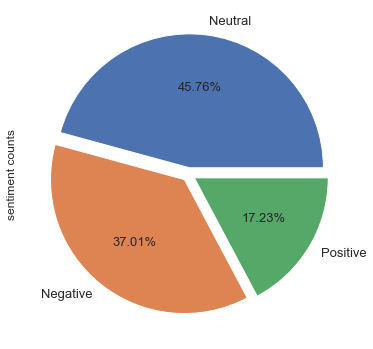

In [92]:
label_count.plot(kind = 'pie', autopct = "%.2f%%", figsize = (6,10), \
    explode = (0.05, 0.05, 0.05), fontsize = 13, label = 'sentiment counts');

## Preprocessing

## Cleaning up data, removing special characters, removing stop words of no sematic value

In [93]:
import preprocess_kgptalkie as ps  # import the cleaning package
import re # regular expression

In [94]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_rt(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

## Apply the cleaning into the dataframe

In [95]:
tweets["tweet_text"] = tweets["tweet_text"].apply( lambda  x: get_clean(x))
tweets.head()

,_id,tweet_text,tweet_lang,tweet_sentiment_value,label
0,595e60b48fcd022a715f7b7b,this airfrance b7300er has the oldest ifes i h...,en,0,Negative
1,595e60de8fcd022a715f7b7d,will miss my connection airfrance,en,0,Negative
2,595e61448fcd022a715f7b7f,airfrance lost luggage in overhead cabin email...,en,0,Negative
3,595e62748fcd022a715f7b83,heres a new twist on the all airlines hate mus...,en,0,Negative
4,595e62b28fcd022a715f7b86,airfrance so now i might not have 3 pieces of ...,en,0,Negative


## Split data into X and y

In [96]:
X = tweets["tweet_text"]
y =np.array( tweets["label"])


In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [98]:
vectorizer = TfidfVectorizer(max_features = 5000, ngram_range =(1,2))

In [120]:
vectorizer.get_feature_names_out()[:20]

array(['003490', '08', '10', '10 days', '10 years', '100', '100am',
       '100am jul', '10th', '11', '12', '12th', '13', '1324', '14',
       '14 days', '15', '15 min', '195', '195 per'], dtype=object)

In [99]:
X = vectorizer.fit_transform(X)
# y = vectorizer.fit_transform(y)

In [100]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
X_res, y_res = sm.fit_resample(X, y)

In [101]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.3, random_state = 42)

## TFIDF

In [102]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression(random_state= 42 )
lgr.fit(X_res, y_res)

lgr.score(X_test, y_test), lgr.score(X_train, y_train)

(0.9778761061946902, 0.9667931688804554)

In [103]:
from sklearn import svm
svm = svm.SVC(random_state= 42)
svm.fit(X_train, y_train)

svm.score(X_test, y_test), svm.score(X_train, y_train)

(0.7853982300884956, 0.9933586337760911)

In [104]:
from sklearn.ensemble import RandomForestClassifier
clf= RandomForestClassifier(n_estimators = 100, n_jobs = 1)
clf.fit(X_train, y_train)

clf.score(X_test, y_test), clf.score(X_train, y_train), 

(0.7809734513274337, 0.9971537001897534)

In [105]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(X_train, y_train)

kn.score(X_test, y_test), kn.score(X_train, y_train), 

(0.5530973451327433, 0.6802656546489564)

## Prediction and evaluation

In [118]:
y_pred =lgr.predict(X_test)

In [107]:
from sklearn.metrics import classification_report, confusion_matrix

In [108]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

    Negative       0.98      0.98      0.98       156
     Neutral       0.97      0.96      0.97       142
    Positive       0.98      0.99      0.98       154

    accuracy                           0.98       452
   macro avg       0.98      0.98      0.98       452
weighted avg       0.98      0.98      0.98       452



In [109]:
cm = confusion_matrix(y_test, y_pred)
cm
cmplot = pd.DataFrame(cm , columns=["Negative","Neutral","Positive"], index=["Negative","Neutral","Positive"])
cmplot

,Negative,Neutral,Positive
Negative,153,2,1
Neutral,3,137,2
Positive,0,2,152


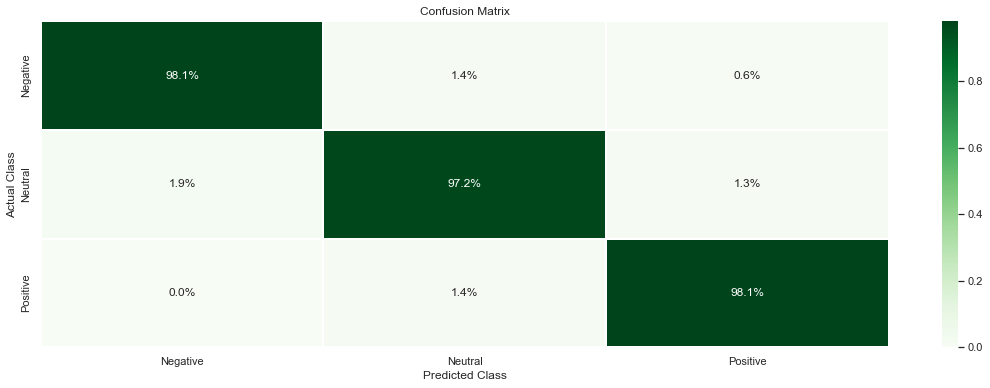

In [110]:
fig, ax = plt.subplots(figsize = (19,6))
sns.heatmap(cmplot/np.sum(cmplot), fmt= '.1%' ,linewidth=0.3, cmap = 'Greens',xticklabels = True, annot =True)
ax.set(title = 'Confusion Matrix', xlabel = 'Predicted Class', ylabel = 'Actual Class');

# lets visualize and compare on bar chart

## Save with joblib

In [111]:
import joblib
joblib.dump(svm, 'tweet_model.joblib')

['tweet_model.joblib']

In [112]:
import pickle
pickle.dump(svm, open("tweet_model.pkl", "wb"))

# loading the model to compare the actual vs predicted in terms of counts

In [113]:
loaded = joblib.load("tweet_model.joblib")

In [114]:
predicted = loaded.predict(X)

In [115]:
retest = pd.concat([tweets,pd.DataFrame(predicted, columns =['predicted'])], ignore_index = False, axis =1)
retest.sample(10)

,_id,tweet_text,tweet_lang,tweet_sentiment_value,label,predicted
1067,5969447f976f440300c0f4e1,govmikehuckabee airfrance i heard they have fa...,en,2,Positive,Neutral
514,59603501745dc32c7a70a940,airfrance would not let me direct message but ...,en,1,Neutral,Neutral
304,5963fe244fe31f4f52a02387,do not worry airfrance i will keep you updated...,en,0,Negative,Negative
508,5960229e745dc32c7a70a922,onemileatatime you think your 200k redemption ...,en,1,Neutral,Neutral
798,596474e14fe31f4f52a02411,airfrance your online system would not let me ...,en,1,Neutral,Neutral
907,596c69d5976f440300c0fafb,woman banned from air france after slapping ai...,en,1,Neutral,Neutral
101,595f8392745dc32c7a70a7a3,amelbenchikh airfrance afnewsroom airfrance su...,en,0,Negative,Neutral
586,59621741beec944b5ec2d470,jerome sullivan airfrance i guessed so used to...,en,1,Neutral,Neutral
216,5962be914fe31f4f52a02065,airfrance please send me my instrument and lug...,en,0,Negative,Negative
556,5960bddf745dc32c7a70aa31,richard purves airfrance chuck the peasants so...,en,1,Neutral,Neutral


In [116]:
compare = pd.concat([retest["label"].value_counts(),retest["predicted"].value_counts()], ignore_index = False, axis = 1)
compare

,label,predicted
Neutral,502,540
Negative,406,394
Positive,189,163


<AxesSubplot:>

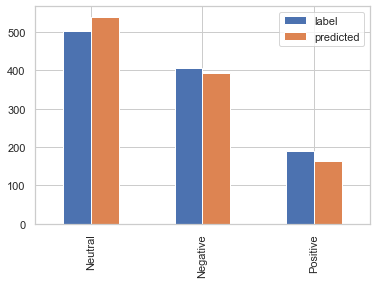

In [117]:
compare.plot(kind = "bar",)